# 09 NMI RT-CO communities
We use the Normalized Mutual Information (NMI) between the partitions obtained with communities in Retweets (RT) and Cosharing (CO) networks to measure the echo chamber effect.
If the partitions are similar, it means that users are interacting with users having the same opinion (since they shared the same contents), implying that the echo chamber effect is high.

NMI is a value in [0,1], that is computed with normalized_mutual_info_score or adjusted_mutual_info_score (giving very similar results).
We compute the NMI for all the networks and show few statistics.

The data about NMI will be recomputed in a later moment, when all the information about the networks will be computed.

In [49]:
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from sklearn.metrics.cluster import adjusted_mutual_info_score as ami
import pandas as pd
from glob import glob
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
#data on edges and users are stored in this folder
folder = "/data/public/jlenti/multilang-vax/EuropeAmerica_RTCO"

#list of all countries (size ordered)
countries = ["US", "BR", "AR", "GB", "ES", "MX", "FR", "CA", "TR", "VE", "AU", "CO", "IT", "CL", "DE",
             "PT", "IE", "PY", "EC", "RU", "UY", "NZ", "PL", "NL", "PE", "CU", "PA", "GR"]

#sorted by language
lang_sort = ["US", "IE", "GB", "CA", "NZ", "AU", "FR", "IT", "PL", "NL", "DE", "RU", "TR", 
             "BR", "PT", "GR", "AR", "ES", "MX","VE", "CO", "CL",
             "PY", "EC", "UY", "PE", "CU", "PA"]

#named periods
periods = ["period" + str(u + 1) for u in range(4)]

In [4]:
#easy way to get data from the folder, just giving as input country, period, and object needed, 
#getting the file names with glob
def read_data(country, period, obj, layer):
    files = sorted(glob("/".join([folder, period, country + "*" + layer + "_" + obj + "*"])))[0]
    return pd.read_csv(files)

### Example

In [12]:
country, period = "IT", "period1"

In [13]:
#get data about users
RT_com = read_data(country, period, "com", "RT") #communities of RT networks
CO_com = read_data(country, period, "com", "CO") #communities of CO networks
        

In [17]:
layers_coms = RT_com.merge(CO_com, on = "user", suffixes = ["_RT", "_CO"]) #merge the two communities, having only users in both networks
layers_coms.head()

,user,community_RT,community_CO
0,000Salvatore,1,3
1,moschettopres,1,1
2,RobertoBurioni,2,4
3,repubblica,2,5
4,1950_anna,1,1


In [18]:
nmi_RTCO = nmi(layers_coms["community_RT"], layers_coms["community_CO"])
ami_RTCO = ami(layers_coms["community_RT"], layers_coms["community_CO"])


In [19]:
nmi_RTCO, ami_RTCO

(0.35701585893914084, 0.353310714794155)

## All Networks

In [58]:
nmi_stats = []
for period in periods:
    for country in countries:
        RT_com = read_data(country, period, "com", "RT") #communities of RT networks
        CO_com = read_data(country, period, "com", "CO") #communities of CO networks
        RT_coms = RT_com["community"].max() #number of RT communities
        CO_coms = CO_com["community"].max() #number of CO communities
        RT_large_coms = (RT_com["community"].value_counts() / len(RT_com)).cumsum().reset_index() \
        .query("community > 0.9")["index"].tolist()[0] #number of communities covering 90% of nodes
        CO_large_coms = (CO_com["community"].value_counts() / len(CO_com)).cumsum().reset_index() \
        .query("community > 0.9")["index"].tolist()[0] #number of communities covering 90% of nodes
        
        layers_coms = RT_com.merge(CO_com, on = "user", suffixes = ["_RT", "_CO"]) #merge the two communities, having only users in both networks
        users = len(layers_coms)
        nmi_RTCO = nmi(layers_coms["community_RT"], layers_coms["community_CO"]) #nmi
        ami_RTCO = ami(layers_coms["community_RT"], layers_coms["community_CO"]) #ami
        nmi_stats.append([country, period, users, RT_coms, CO_coms, RT_large_coms, CO_large_coms, nmi_RTCO, ami_RTCO])

In [59]:
#create the dataframe only with countries, periods, #communities and nmi
nmi_stats_df = pd.DataFrame(nmi_stats, columns = ["country", "period", "users", "RT_coms", "CO_coms", "RT_large_coms",
                                                  "CO_large_coms", "nmi", "ami"])

#### Mean

In [60]:
nmi_stats_df.mean()

<ipython-input-60-a7969d1e3570>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  nmi_stats_df.mean()


users            6979.785714
RT_coms             6.696429
CO_coms             4.883929
RT_large_coms       2.741071
CO_large_coms       3.196429
nmi                 0.238972
ami                 0.229607
dtype: float64

#### Correlation between NMI and other stats

In [90]:
nmi_stats_df.corr()["nmi"]

users            0.302384
RT_coms          0.113147
CO_coms         -0.145935
RT_large_coms   -0.140286
CO_large_coms   -0.411923
nmi              1.000000
ami              0.984372
Name: nmi, dtype: float64

## #Large Communities vs NMI

[Text(2, 0, '2'), Text(3, 0, '3'), Text(4, 0, '4'), Text(5, 0, '5')]

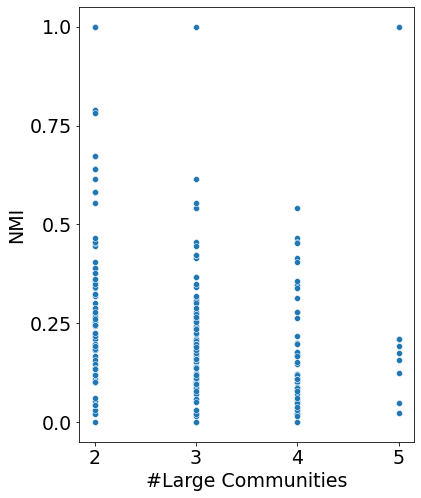

In [79]:
fig, axes = plt.subplots(1,1,figsize = [6,8])

df = pd.concat([nmi_stats_df[["RT_large_coms", "nmi"]].rename(columns = {"RT_large_coms": "large_coms"}), 
           nmi_stats_df[["CO_large_coms", "nmi"]].rename(columns = {"CO_large_coms": "large_coms"})])
sns.scatterplot(data = df, x = "large_coms", y = "nmi")

axes.set_ylabel("NMI", fontsize = 19)
axes.set_yticks(0.25 * np.arange(0, 5))
axes.set_yticklabels(0.25 * np.arange(0, 5) , fontsize = 19)

axes.set_xlabel("#Large Communities", fontsize = 19)
axes.set_xticks(np.arange(0, 4) + 2)
axes.set_xticklabels(np.arange(0, 4) + 2, fontsize = 19)

## #Users vs NMI

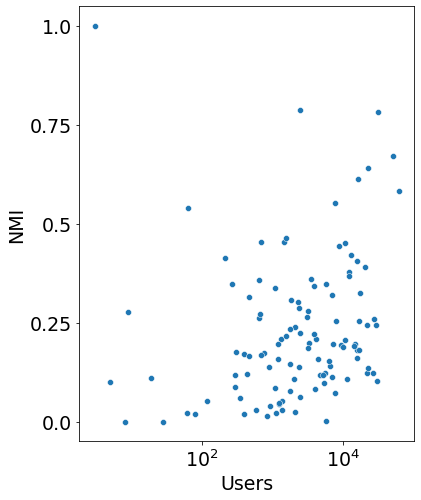

In [86]:
fig, axes = plt.subplots(1,1,figsize = [6,8])

sns.scatterplot(data = nmi_stats_df, x = "users", y = "nmi")

axes.set_ylabel("NMI", fontsize = 19)
axes.set_yticks(0.25 * np.arange(0, 5))
axes.set_yticklabels(0.25 * np.arange(0, 5) , fontsize = 19)

axes.set_xlabel("Users", fontsize = 19)
axes.set_xscale("log")
axes.tick_params(axis = "x", labelsize = 19)

## NMI vs AMI

[Text(0.0, 0, '0.0'),
 Text(0.25, 0, '0.25'),
 Text(0.5, 0, '0.5'),
 Text(0.75, 0, '0.75'),
 Text(1.0, 0, '1.0')]

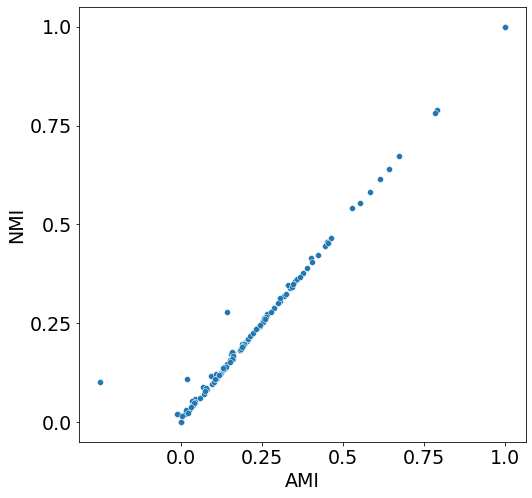

In [87]:
fig, axes = plt.subplots(1,1,figsize = [8,8])

sns.scatterplot(data = nmi_stats_df, x = "ami", y = "nmi")

axes.set_ylabel("NMI", fontsize = 19)
axes.set_yticks(0.25 * np.arange(0, 5))
axes.set_yticklabels(0.25 * np.arange(0, 5) , fontsize = 19)

axes.set_xlabel("AMI", fontsize = 19)
axes.set_xticks(0.25 * np.arange(0, 5))
axes.set_xticklabels(0.25 * np.arange(0, 5) , fontsize = 19)


## NMI over time

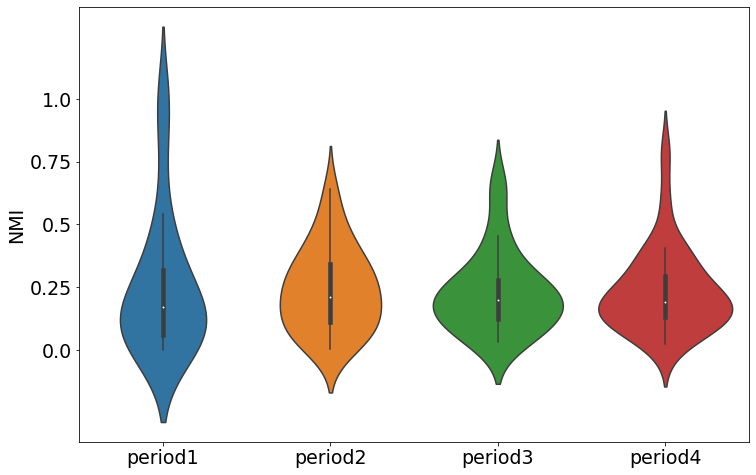

In [95]:
fig, axes = plt.subplots(1,1,figsize = [12,8])

sns.violinplot(data = nmi_stats_df, x = "period", y = "nmi")

axes.set_ylabel("NMI", fontsize = 19)
axes.set_yticks(0.25 * np.arange(0, 5))
axes.set_yticklabels(0.25 * np.arange(0, 5) , fontsize = 19)

axes.set_xlabel("", fontsize = 19)
axes.tick_params(axis = "x", labelsize = 19)

## Countries vs NMI

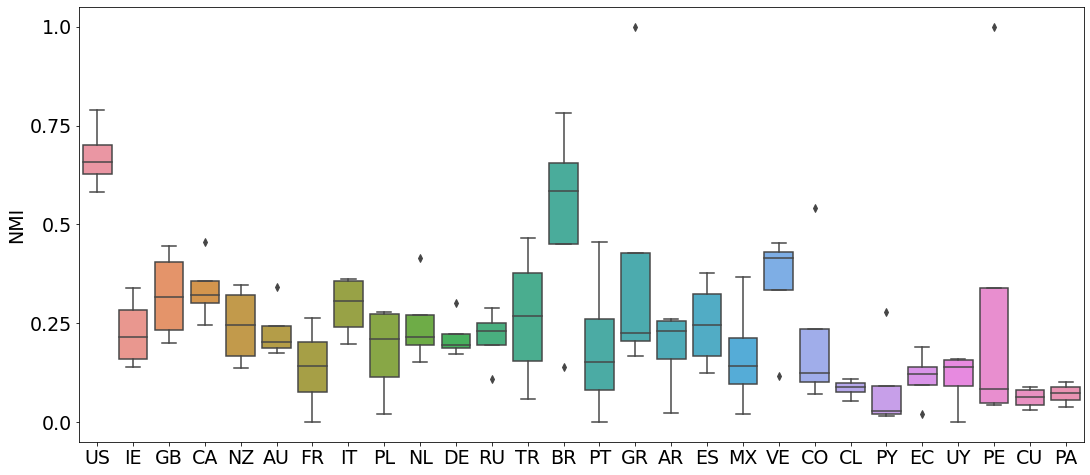

In [105]:
fig, axes = plt.subplots(1,1,figsize = [18,8])

sns.boxplot(data = nmi_stats_df.set_index("country").loc[lang_sort].reset_index(), 
            x = "country", y = "nmi")

axes.set_ylabel("NMI", fontsize = 19)
axes.set_yticks(0.25 * np.arange(0, 5))
axes.set_yticklabels(0.25 * np.arange(0, 5) , fontsize = 19)

axes.set_xlabel("", fontsize = 19)
axes.tick_params(axis = "x", labelsize = 19)

#### Is NMI higher in English speaking countries w.r.t. Spanish speakers?

In [111]:
en_countries = ["US", "IE", "GB", "CA", "NZ", "AU"]
es_countries = ["ES", "MX","VE", "CO", "CL", "PY", "EC", "UY", "PE", "CU", "PA"]

In [112]:
print("Average NMI English speaking countries", nmi_stats_df.query("country in @en_countries")["nmi"].mean())
print("Average NMI Spanish speaking countries", nmi_stats_df.query("country in @es_countries")["nmi"].mean())

Average NMI English speaking countries 0.3378011418839358
Average NMI Spanish speaking countries 0.16443439283513073


Is significantly diffrent?

**t-test**

$H_0$: English and Spanish speaking countries have the same average NMI



In [113]:
ttest_ind(nmi_stats_df.query("country in @en_countries")["nmi"],
          nmi_stats_df.query("country in @es_countries")["nmi"])

Ttest_indResult(statistic=3.7455517732989208, pvalue=0.00038038932780286164)

p-value < 0.001

Reject $H_0$: English speaking countries NMI is significantly higher than Spanish speaking countries.